# Определение языка и VK API

В данном задании вам нужно будет:

* используя API Вконтакте, скачать комментарии к первым ста постам из пяти сообществ
* натренировать модель распознавания языков на статьях из Википедии.
* распознать язык всех комментариев, где в тексте есть 10 и более символов, и построить статистику

## VK API

Для подключения к ВКонтакте мы будем использовать VK API. Здесь есть документация к этой библиотеке https://vk-api.readthedocs.io/en/latest/

In [ ]:
!pip install vk_api

In [41]:
import vk_api
from config import user, password

# авторизация
vk_session = vk_api.VkApi(login=user, password=password)
vk_session.auth()

vk = vk_session.get_api() # объект с API

Получить записи со страницы можно с помощью метода `wall.get`. Он принимает параметр `domain` — короткое имя пользователя или сообщества — и `count` — количество записей, которое вы хотите получить (максимум — 100). По Список методов для работы со стенами: https://vk.com/dev/wall

Например, вот так можно получить последние две записи с вот этой страницы https://vk.com/futureisnow. Выдача представляет собой словарь, в котором в поле `items` записан список словарей, содержащий информацию о каждой из записи. 

In [2]:
vk.wall.get(domain="futureisnow", count=2)

{'count': 8173,
 'items': [{'id': 249625,
   'from_id': -111587102,
   'owner_id': -111587102,
   'date': 1569577800,
   'marked_as_ads': 0,
   'post_type': 'post',
   'text': 'Пришла эпоха',
   'signer_id': 92744050,
   'attachments': [{'type': 'photo',
     'photo': {'id': 457288456,
      'album_id': -7,
      'owner_id': -111587102,
      'user_id': 100,
      'sizes': [{'type': 'm',
        'url': 'https://sun1-30.userapi.com/c7004/v7004688/74669/NgBW3Tj3y7s.jpg',
        'width': 94,
        'height': 130},
       {'type': 'o',
        'url': 'https://sun1-90.userapi.com/c7004/v7004688/7466d/2ZkDR5cdQR0.jpg',
        'width': 130,
        'height': 180},
       {'type': 'p',
        'url': 'https://sun1-30.userapi.com/c7004/v7004688/7466e/7AjKxrJqJF0.jpg',
        'width': 200,
        'height': 277},
       {'type': 'q',
        'url': 'https://sun1-27.userapi.com/c7004/v7004688/7466f/438ntNLM7jc.jpg',
        'width': 320,
        'height': 443},
       {'type': 'r',
        'u

С помощью метода `groups.getById` можно получить информацию о сообществе, в том числе его id.

In [3]:
vk.groups.getById(group_ids="futureisnow")

[{'id': 111587102,
  'name': 'киберпанк, который мы заслужили',
  'screen_name': 'futureisnow',
  'is_closed': 0,
  'type': 'page',
  'is_admin': 0,
  'is_member': 1,
  'is_advertiser': 0,
  'photo_50': 'https://sun1-29.userapi.com/c845124/v845124938/4b879/-EzOFg-vjTg.jpg?ava=1',
  'photo_100': 'https://sun1-14.userapi.com/c845124/v845124938/4b878/Lr9NW4jLxOU.jpg?ava=1',
  'photo_200': 'https://sun1-85.userapi.com/c845124/v845124938/4b877/dqfgJ42Ir5E.jpg?ava=1'}]

Скачайте информацию о последних ста записях в следующих пабликах: https://vk.com/futureisnow, https://vk.com/eternalclassic, https://vk.com/ukrlit_memes, https://vk.com/ukrainer_net, https://vk.com/amanzohel, https://vk.com/barg_kurumk_culture

In [42]:
# список domain'ов, чтобы вам не копировать их самими :)
publics = ["futureisnow",
           "eternalclassic",
           "ukrlit_memes",
           "ukrainer_net",
           "amanzohel",
           "barg_kurumk_culture"]

In [43]:
items = {} # ключи — это паблики

for domain in publics:
    res = vk.wall.get(domain=domain, count=100)
    items[domain] = res['items']

Найдите в документации (https://vk.com/dev/wall) метод для получения комментариев и получите первые сто комментариев каждого поста из выборки для каждого паблика.

In [44]:
corpora = {}

for domain in publics:
    corpora[domain] = []
    for post in items[domain]:
        res = vk.wall.getComments(owner_id=post['owner_id'], post_id=post['id'], count=100)
        corpora[domain].append(res['items'])

In [51]:
corpora_clean = {}

for domain in publics:
    corpora_clean[domain] = []
    for comments in corpora[domain]:
        for comment in comments:
            try:
                if len(comment['text']) > 10:
                    corpora_clean[domain].append(
                        {
                            'text': comment['text'],
                            'lang_s': '',
                            'lang_c': ''
                        }
                    )
                else:
                    continue
            except KeyError:
                continue

In [52]:
corpora_clean

{'futureisnow': [{'text': 'у вас мать валяется', 'lang_s': '', 'lang_c': ''},
  {'text': 'Это жестоко', 'lang_s': '', 'lang_c': ''},
  {'text': 'Нельзя с матерью так обращаться', 'lang_s': '', 'lang_c': ''},
  {'text': 'Бедная мамка', 'lang_s': '', 'lang_c': ''},
  {'text': 'Любая мать на интеловском чипсете через 1-2 года',
   'lang_s': '',
   'lang_c': ''},
  {'text': 'ничего страшного...', 'lang_s': '', 'lang_c': ''},
  {'text': 'мы всё поймём...', 'lang_s': '', 'lang_c': ''},
  {'text': 'так даже лучше', 'lang_s': '', 'lang_c': ''},
  {'text': 'а я не прощаю...', 'lang_s': '', 'lang_c': ''},
  {'text': 'мало... точек....', 'lang_s': '', 'lang_c': ''},
  {'text': 'казнить нельзя помиловать?\nвосстание мошин',
   'lang_s': '',
   'lang_c': ''},
  {'text': 'казните его...', 'lang_s': '', 'lang_c': ''},
  {'text': 'Типичный студент Казахстана', 'lang_s': '', 'lang_c': ''},
  {'text': 'Пацан тоже напечатаный?', 'lang_s': '', 'lang_c': ''},
  {'text': 'Зажевало...', 'lang_s': '', 'lang_c

In [53]:
for domain, comments in corpora_clean.items():
    print(domain, len(comments))

futureisnow 1149
eternalclassic 741
ukrlit_memes 245
ukrainer_net 199
amanzohel 235
barg_kurumk_culture 227


**Задание со звездочкой:** вы могли заметить, что если обращаться к каждому посту отдельно, то все занимает довольно продолжительное время (около пяти минут). Найдите в документации vk_api способ сделать это быстрее.

In [ ]:
corpora = {}

# ваш улучшенный код

**NB**: я не очень поняла, что имеется в виду, т.к. метод getComments не позволяет передать ему сразу 100 id постов (если верить документации).

## Тренировка моделей

В наших комментариях встречались русский, украинский, английский и бурятский.

In [54]:
from collections import Counter  # нужно объяснять, что это?

import nltk
import wikipedia

langs = {'ru', 'uk', 'en', 'bxr'}

Скачайте документы, на которых вы будете обучать свои модели. Для наших целей хорошо иметь для каждого языка корпус размером около 50 статей.

In [57]:
def get_texts_for_lang(lang, n=10):
    wiki_content = []
    wikipedia.set_lang(lang)
    pages = wikipedia.random(n)
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
            wiki_content.append("%s\n%s" % (page.title, page.content.replace('=', '')))
        except wikipedia.exceptions.WikipediaException:
            print("Skip %s" % page_name)
    return wiki_content

wiki_texts = {}
for lang in langs:
    wiki_texts[lang] = get_texts_for_lang(lang, 50)
    print(lang, len(wiki_texts[lang]))

Skip Nimrud (disambiguation)
Skip Pygmalion (opera)
Skip Simon Robinson
Skip KCQX
en 46
bxr 50
Skip Асадуллин (значения)
Skip Борковец
Skip Балд (значения)
Skip DAP
ru 46
Skip Сен-Венсан-де-Пре
uk 49


Сделайте определялку на частотах слов.

In [58]:
def collect_freqlist(wiki_pages, max_len=100):
    freqlist = Counter()
    # не забудем про токенизацию - nltk.word_tokenize
    for text in wiki_pages:
        for word in nltk.word_tokenize(text.lower()):
            if word.isalpha():
                freqlist[word] += 1
    return dict(freqlist.most_common(max_len))

freq_lists = {}
for lang in langs:
    freq_lists[lang] = collect_freqlist(wiki_texts[lang])
    
def simple_lang_detect(freq_lists, text):
    counts = Counter()
    for lang, freq_list in freq_lists.items():
        freq_list = Counter(freq_list)
        for word in nltk.word_tokenize(text):
            counts[lang] += int(freq_list[word] > 0)
    return counts.most_common()

Сделайте определялку на символьных энграммах.

In [59]:
from sklearn import feature_extraction
from sklearn import pipeline
from sklearn import naive_bayes
import numpy as np

clf = pipeline.Pipeline([
    ('vctr', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2), analyzer='char')),
    ('clf', naive_bayes.MultinomialNB())
])


all_texts = []
lang_indices = []
for lang in wiki_texts:
    all_texts.extend(wiki_texts[lang])
    lang_indices.extend([lang]*len(wiki_texts[lang]))

# Обучаем классификатор
clf.fit(np.array(all_texts), np.array(lang_indices))

def complex_lang_detect(text):
    return clf.predict(text)

# Определение языка

### Метод частотного словаря

Обработка комментариев:

In [60]:
for domain in publics:
    for comment in corpora_clean[domain]:
        res = simple_lang_detect(freq_lists, comment['text'])
        if len(res) > 0:
            if max([i[1] for i in res]) == 0:
                comment['lang_s'] = 'unknown' 
            else:
                comment['lang_s'] = res[0][0]
        else:
            comment['lang_s'] = 'NaN'

Подсчет:

In [69]:
lang_detects_freqs = {}

for domain, comments in corpora_clean.items():
    lang_detects_freqs[domain] = {
        'ru': 0,
        'uk': 0,
        'en': 0,
        'bxr': 0,
        'NaN': 0,
        'unknown': 0
    }
    for comment in comments:
        lang_detects_freqs[domain][comment['lang_s']] += 1

Результат в абсолютных значениях:

In [70]:
lang_detects_freqs

{'futureisnow': {'ru': 669,
  'uk': 25,
  'en': 10,
  'bxr': 24,
  'NaN': 0,
  'unknown': 421},
 'eternalclassic': {'ru': 0,
  'uk': 0,
  'en': 436,
  'bxr': 0,
  'NaN': 0,
  'unknown': 305},
 'ukrlit_memes': {'ru': 61,
  'uk': 84,
  'en': 4,
  'bxr': 0,
  'NaN': 0,
  'unknown': 96},
 'ukrainer_net': {'ru': 42,
  'uk': 84,
  'en': 0,
  'bxr': 1,
  'NaN': 0,
  'unknown': 72},
 'amanzohel': {'ru': 21,
  'uk': 1,
  'en': 0,
  'bxr': 14,
  'NaN': 0,
  'unknown': 199},
 'barg_kurumk_culture': {'ru': 92,
  'uk': 1,
  'en': 0,
  'bxr': 23,
  'NaN': 0,
  'unknown': 111}}

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

Результат в относительных значениях на (относительно) красивом графике:

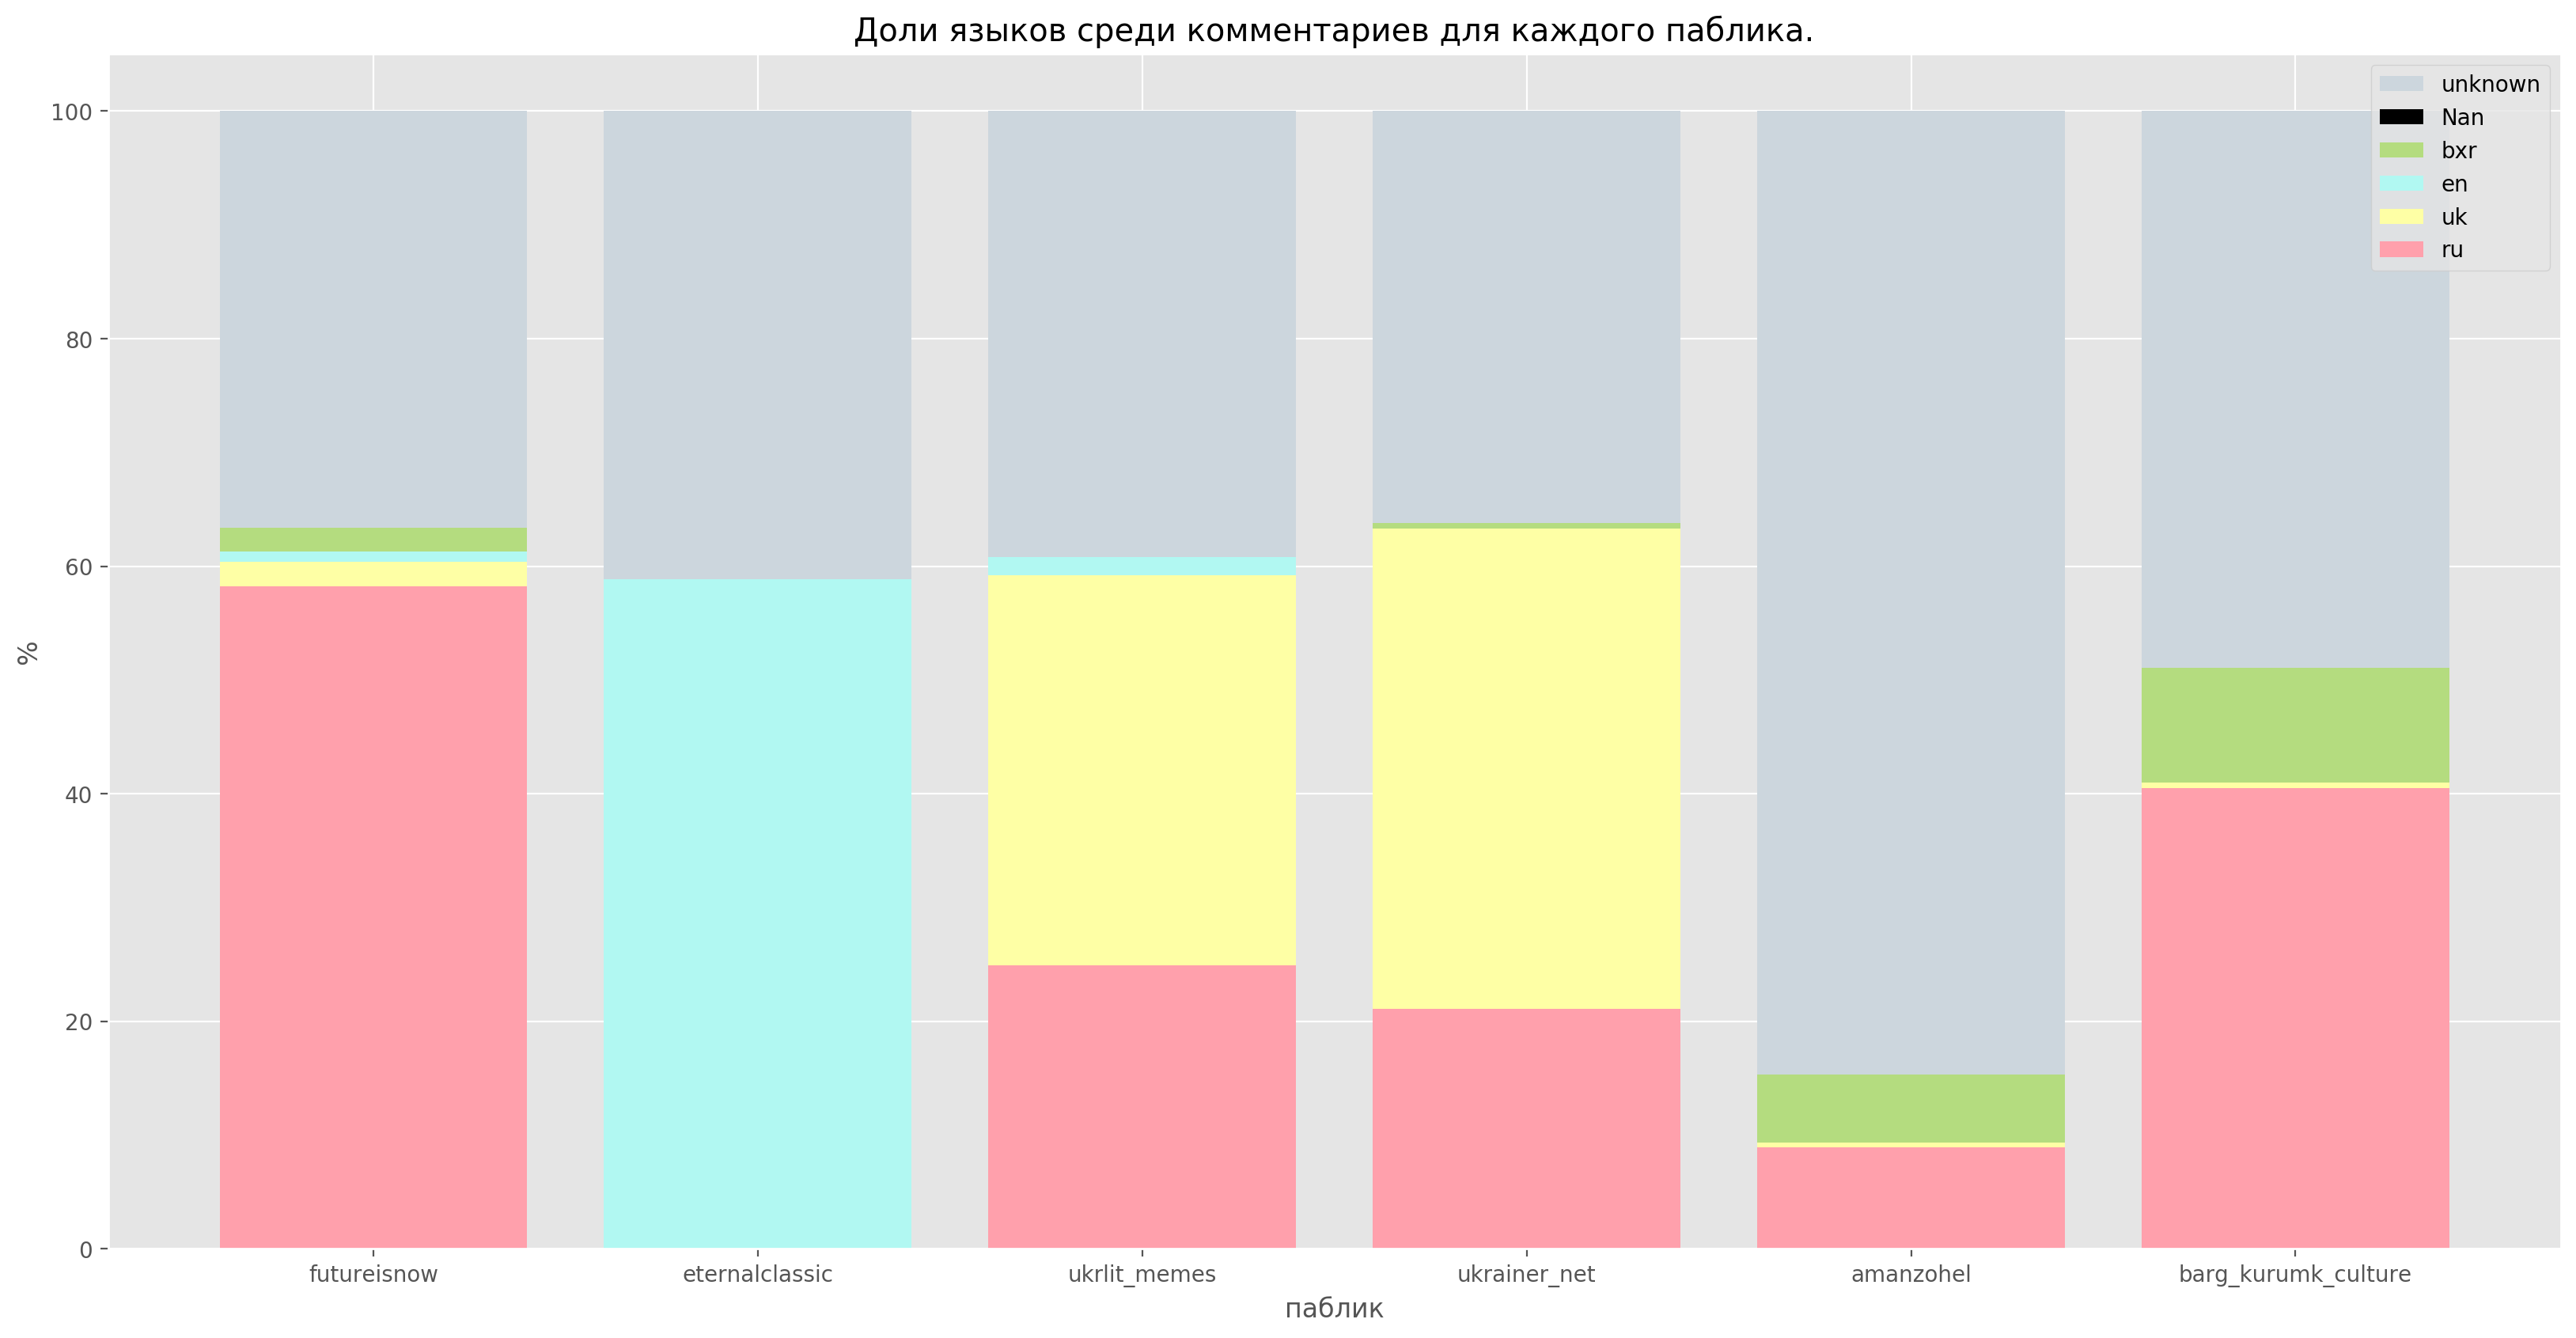

In [78]:
plt.figure(figsize=(20, 10), dpi=200)

for domain, lang_stat in lang_detects_freqs.items():
    colors = iter(['#CCD6DD', 'black', '#B4DC7F', '#B1F8F2', '#FEFFA5', '#FFA0AC'])
    n = 0
    ys = []
    for lang in lang_stat.values():
        n += lang
        ys.append(n)
    for i in range(len(ys)):
        plt.bar(domain, ys[-i-1]*100/ys[-1], color=next(colors))

plt.title("Доли языков среди комментариев для каждого паблика.")
plt.xlabel("паблик")
plt.ylabel("%")
plt.legend(['unknown', 'Nan', 'bxr', 'en', 'uk', 'ru'])      
        
plt.show()

### Метод на символьных н-граммах

Ообработка комментариев и подсчет:

In [73]:
lang_detects_ngrams = {}

for domain in publics:
    for comment in corpora_clean[domain]:
        comment['lang_c'] = complex_lang_detect([comment['text']])[0]


for domain, comments in corpora_clean.items():
    lang_detects_ngrams[domain] = {
        'ru': 0,
        'uk': 0,
        'en': 0,
        'bxr': 0
    }
    for comment in comments:
        lang_detects_ngrams[domain][comment['lang_c']] += 1

Результат в абсолютных значениях:

In [74]:
lang_detects_ngrams

{'futureisnow': {'ru': 1055, 'uk': 22, 'en': 48, 'bxr': 24},
 'eternalclassic': {'ru': 0, 'uk': 0, 'en': 739, 'bxr': 2},
 'ukrlit_memes': {'ru': 86, 'uk': 146, 'en': 6, 'bxr': 7},
 'ukrainer_net': {'ru': 41, 'uk': 148, 'en': 4, 'bxr': 6},
 'amanzohel': {'ru': 36, 'uk': 0, 'en': 0, 'bxr': 199},
 'barg_kurumk_culture': {'ru': 132, 'uk': 3, 'en': 1, 'bxr': 91}}

Результат в относительных значениях на графике:

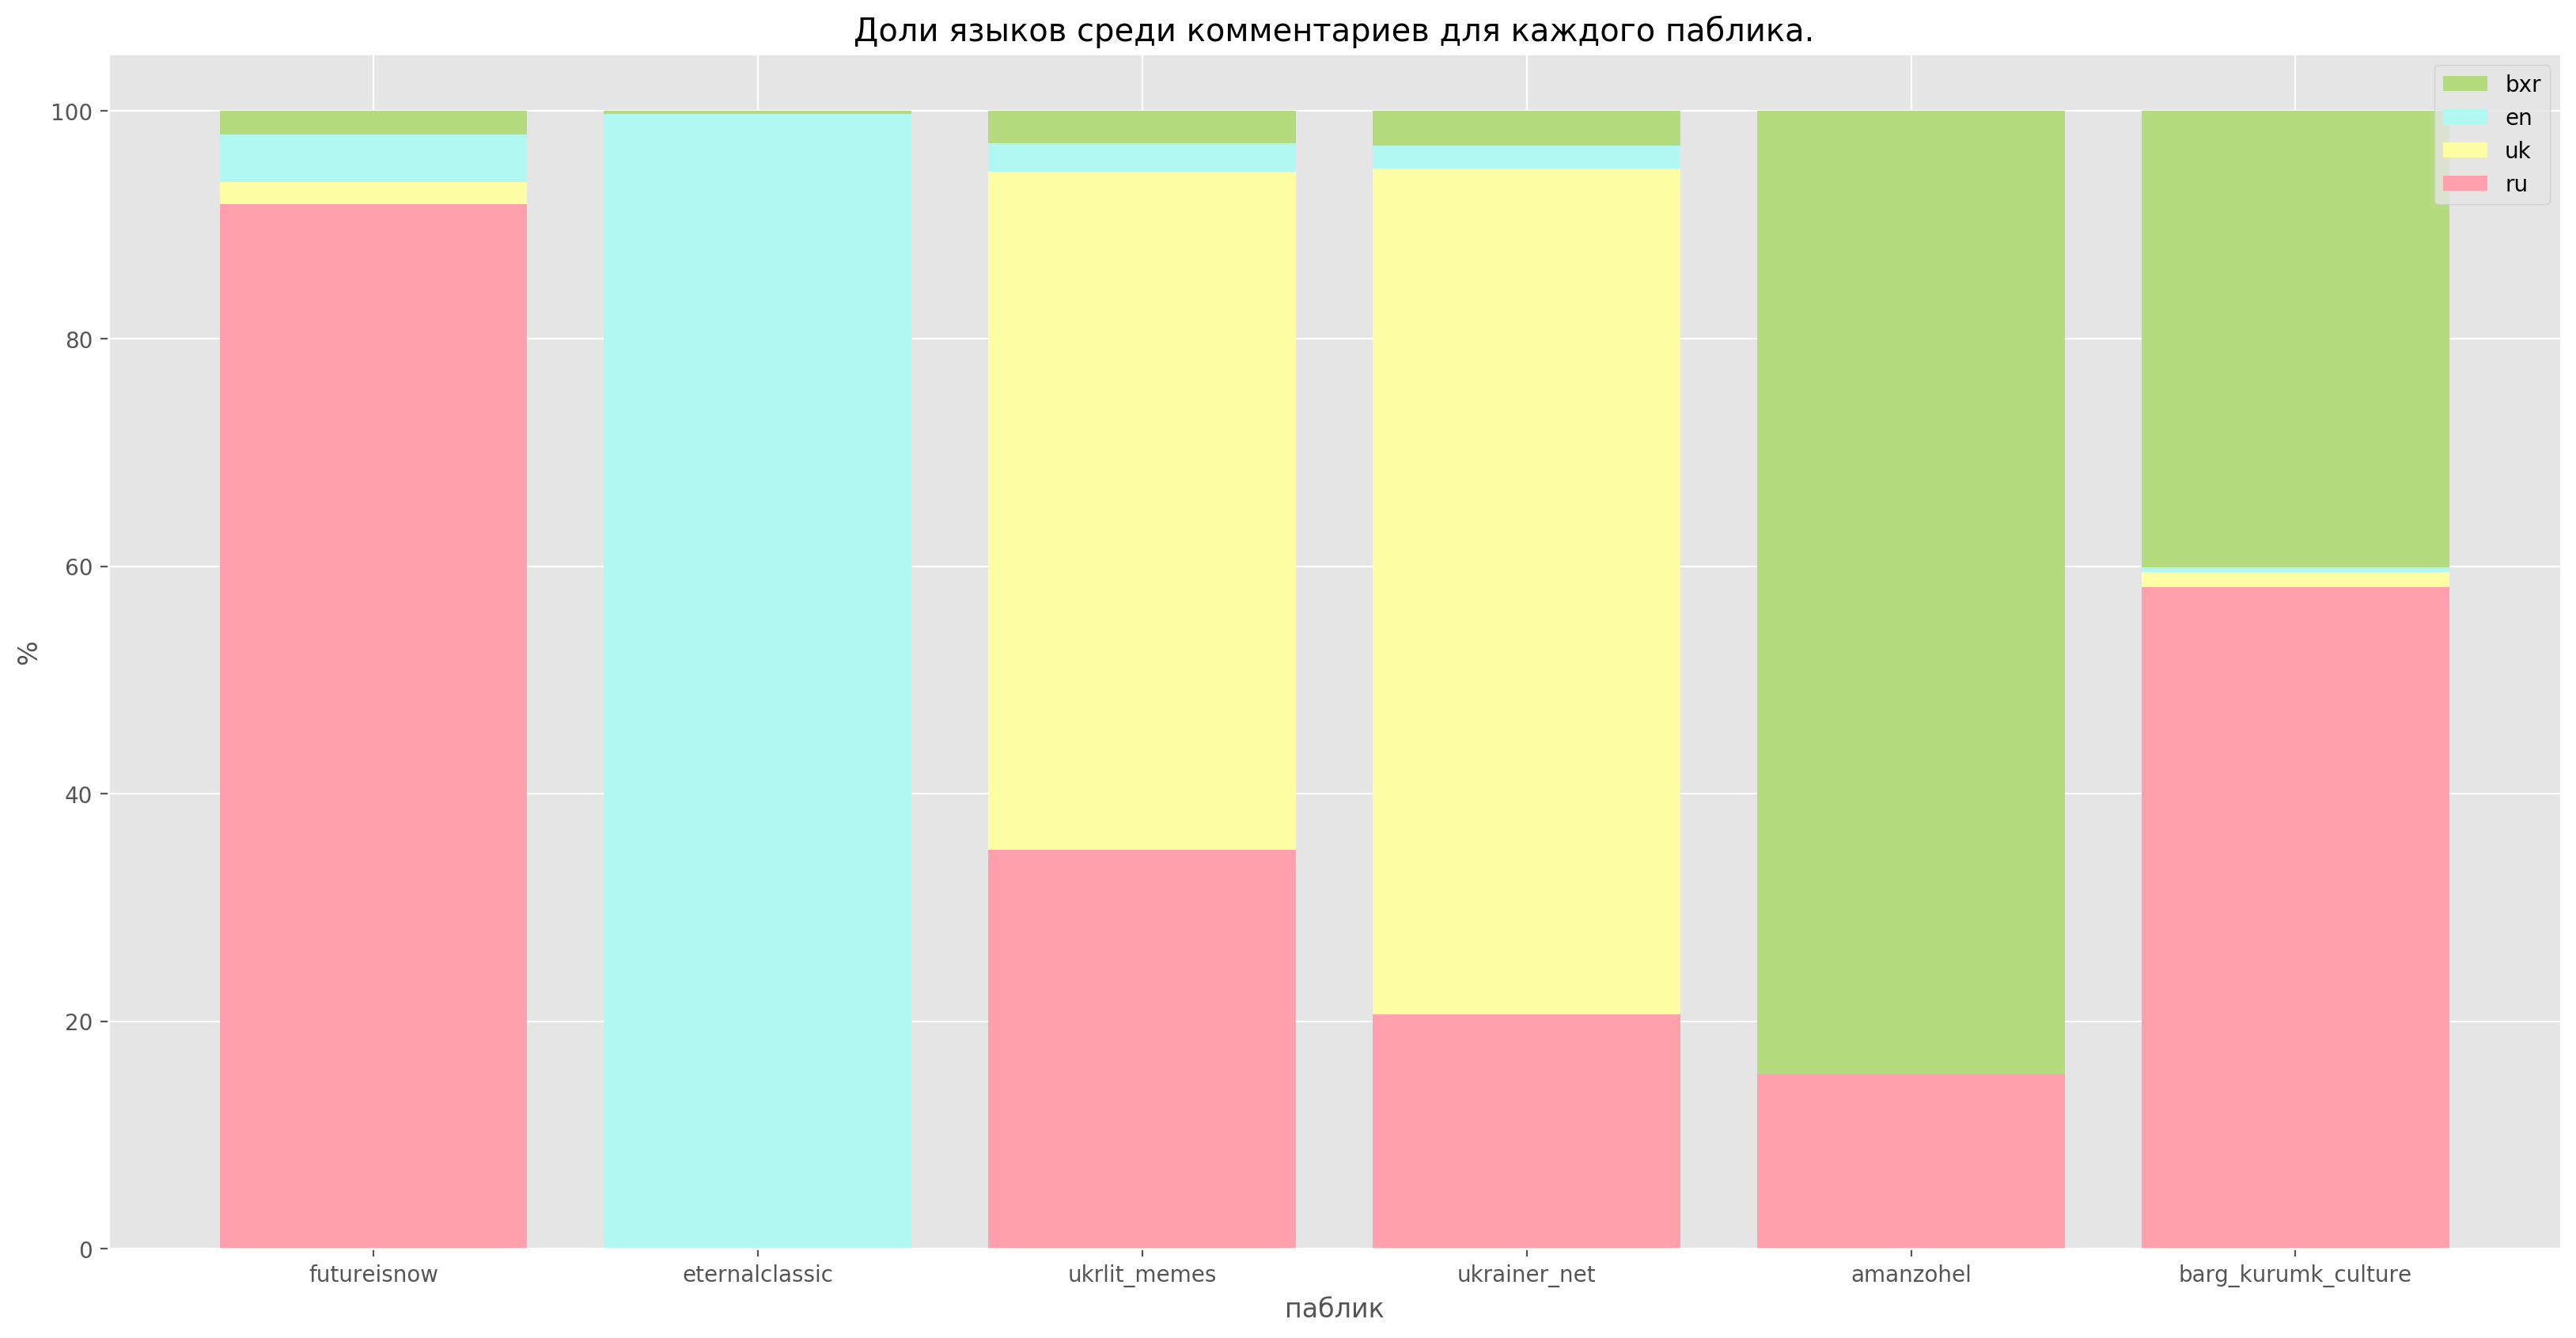

In [77]:
plt.figure(figsize=(20, 10), dpi=200)

for domain, lang_stat in lang_detects_ngrams.items():
    colors = iter(['#B4DC7F', '#B1F8F2', '#FEFFA5', '#FFA0AC'])
    n = 0
    ys = []
    for lang in lang_stat.values():
        n += lang
        ys.append(n)
    for i in range(len(ys)):
        plt.bar(domain, ys[-i-1]*100/ys[-1], color=next(colors))

plt.title("Доли языков среди комментариев для каждого паблика.")
plt.xlabel("паблик")
plt.ylabel("%")
plt.legend(['bxr', 'en', 'uk', 'ru'])     
        
plt.show()

*Обсудите работу каждого из классификаторов, обсудите ошибки, объясните разницу в результатах.*

Классификатор на частотных словарях плохо работает для маленьких текстов (какими являются комментарии, часто не превышающие 10 слов). Кажется, результат может сильно меняться в зависимости от набора текстов для обучения (если использовать всего 50). Специфичная лексика сообщества так же снижает продуктивность этого классификатора. В итоге - очень много "неизвестного", зато не так много неправильно определенных текстов.

Классификатор на символьных н-граммах, наоборот, всегда определяет язык, но не всегда правильно. Как мы обсуждали на семинаре - языки с одинаковыми/похожими алфавитами могут быть перепутаны. Проблема маленькой дины текста не стоит так остро для данного классификатора, но все еще релевантна и влияет на результаты.

Кажется, для задачи анализа комментариев выбранных сообществ второй метод подходит чуть лучше, хотя и  допускает некоторое количество неверных результатов

ср. кол-во комментариев, определенных как бурятские, в следующих сообществах

|сообщество|частотн.слов.|символьные н-граммы|
|----------|-------------|-------------------|
|eternalclassic| 0 | 2 |
|ukrlit_memes| 0 | 7 |